In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
import random
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model
from common import load_image_labels, load_predict_image_names, load_single_image, save_model, load_model

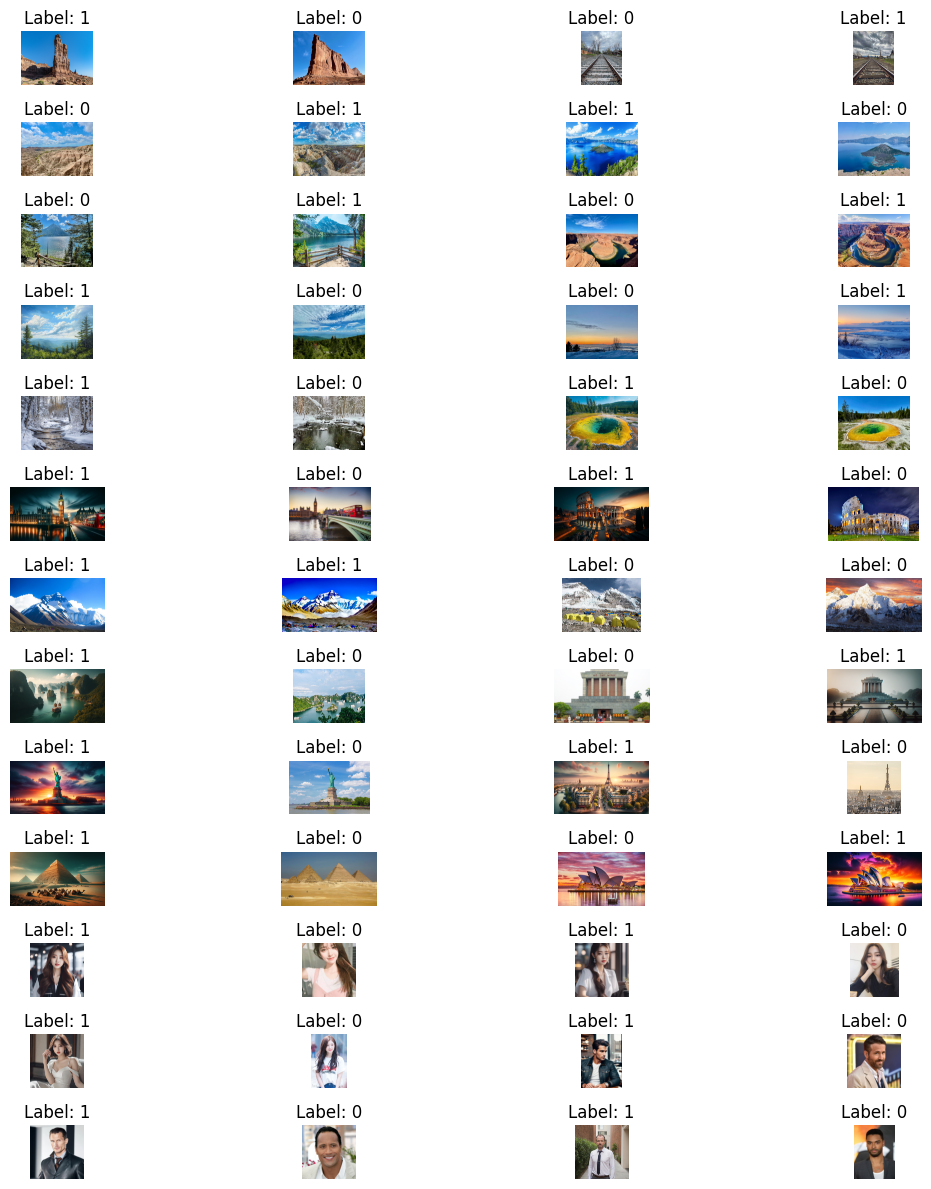

In [2]:
# get label of data

labels_file_path = './data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv'
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]

# get all images
data_path = "./data/Data - Is GenAI - 2024-03-25"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]
num_rows = 13
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

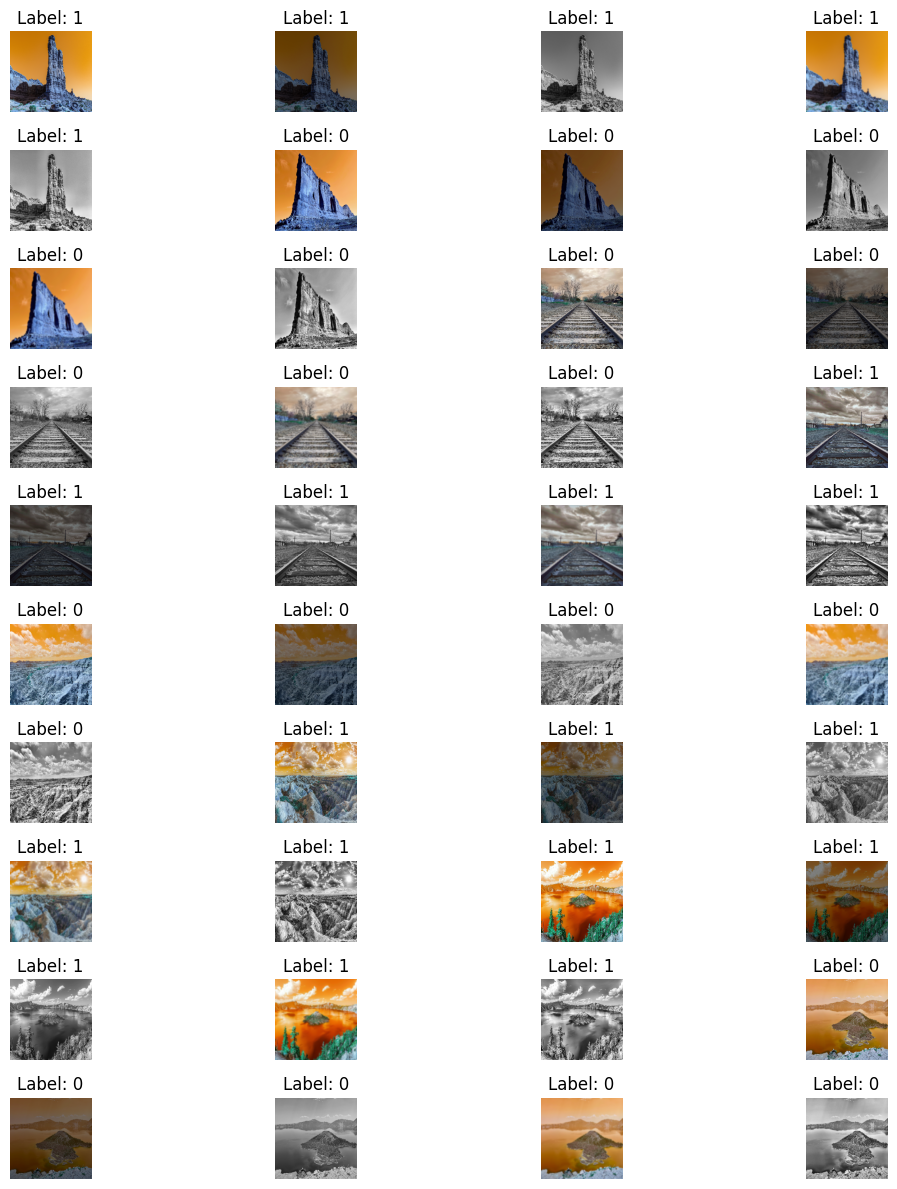

In [3]:
# preprocessed_images = [preprocess_image(image) for image in images]
def preprocess_image_function(image):
    preprocess_image = np.array(image)
    preprocess_image = cv2.resize(preprocess_image, (224, 224))
    preprocess_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    return preprocess_image

def adjust_brightness(image):
    preprocess_image = preprocess_image_function(image)

    hsv_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2HSV)
    brightness_factor = 0.5  # Specify brightness factor
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * brightness_factor, 0, 255)
    brightened_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return brightened_image

def gray_scale(image):
    preprocess_image = preprocess_image_function(image)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_BGR2GRAY)
    # Convert grayscale image to 3-channel format
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

    return gray_image

def apply_gaussian_blur(image):
    preprocess_image = preprocess_image_function(image)
    blurred_image = cv2.GaussianBlur(preprocess_image, (5, 5), 0)
    return blurred_image

def enhance_contrast(image):
    preprocess_image = preprocess_image_function(image)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(preprocess_image, cv2.COLOR_RGB2GRAY)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    # Convert back to 3-channel format
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image

# Apply the preprocess_image function to the image array
preprocessed_images = []
for image in images:
    preprocessed_images.append(preprocess_image_function(image))
    preprocessed_images.append(adjust_brightness(image))
    preprocessed_images.append(gray_scale(image))
    preprocessed_images.append(apply_gaussian_blur(image))
    preprocessed_images.append(enhance_contrast(image))

# get label of data
labels_file_path = "./data/Data - Is GenAI - 2024-03-25/Labels-IsGenAi-2024-03-25.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
# Fix label to be correct with the augment
labels = [label for label in labels for _ in range(5)]

num_rows = 10
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for image, label, ax in zip(preprocessed_images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title("Label: " + str(label))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Split the data into train and test sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

# Convert lists of images to NumPy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# Convert lists of labels to NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [5]:
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

efficientnet_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

Epoch 1/20
401/401 [==============================] - 204s 455ms/step - loss: 0.3066 - accuracy: 0.8779 - val_loss: 0.1921 - val_accuracy: 0.9351 - lr: 2.0000e-04
Epoch 2/20
401/401 [==============================] - 207s 517ms/step - loss: 0.2033 - accuracy: 0.9271 - val_loss: 0.1764 - val_accuracy: 0.9417 - lr: 2.0000e-04
Epoch 3/20
401/401 [==============================] - 227s 567ms/step - loss: 0.1807 - accuracy: 0.9387 - val_loss: 0.1510 - val_accuracy: 0.9498 - lr: 2.0000e-04
Epoch 4/20
401/401 [==============================] - 243s 605ms/step - loss: 0.1616 - accuracy: 0.9445 - val_loss: 0.1360 - val_accuracy: 0.9541 - lr: 2.0000e-04
Epoch 5/20
401/401 [==============================] - 254s 634ms/step - loss: 0.1450 - accuracy: 0.9489 - val_loss: 0.1226 - val_accuracy: 0.9607 - lr: 2.0000e-04
Epoch 6/20
401/401 [==============================] - 261s 651ms/step - loss: 0.1314 - accuracy: 0.9558 - val_loss: 0.1221 - val_accuracy: 0.9594 - lr: 1.2000e-04
Epoch 7/20
401/401 [==

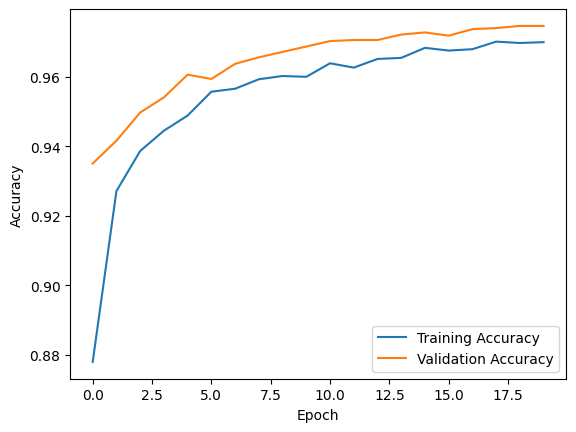

In [6]:
# Actively freeze the layers

# Freeze convolutional layers except for the top 5 layers
for layer in efficientnet_model.layers[:-10]:
    layer.trainable = False

# Define the learning rate decay function
def lr_scheduler(epoch, lr):
    decay_rate = 0.6
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

weight_decay = 1e-5  # Adjust this value as needed


# Compile the model with SGD optimizer and initial learning rate
initial_learning_rate = 0.0002
sgd = SGD(learning_rate=initial_learning_rate)


#Define the learning rate scheduler
lr_callback = LearningRateScheduler(lr_scheduler)

# Add classification head
model = Sequential([
    efficientnet_model,
    Flatten(),
    Dropout(0.4),  # Add dropout,
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dropout(0.4),  # Add dropout,
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(weight_decay))
])

# Compile the model
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the scheduler callback
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=20, batch_size=32, verbose=1,
                    callbacks=[lr_callback])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Save the model weight
model.save_weights("weights/ai_human_classify_model_weights_efficientnetb7.h5")

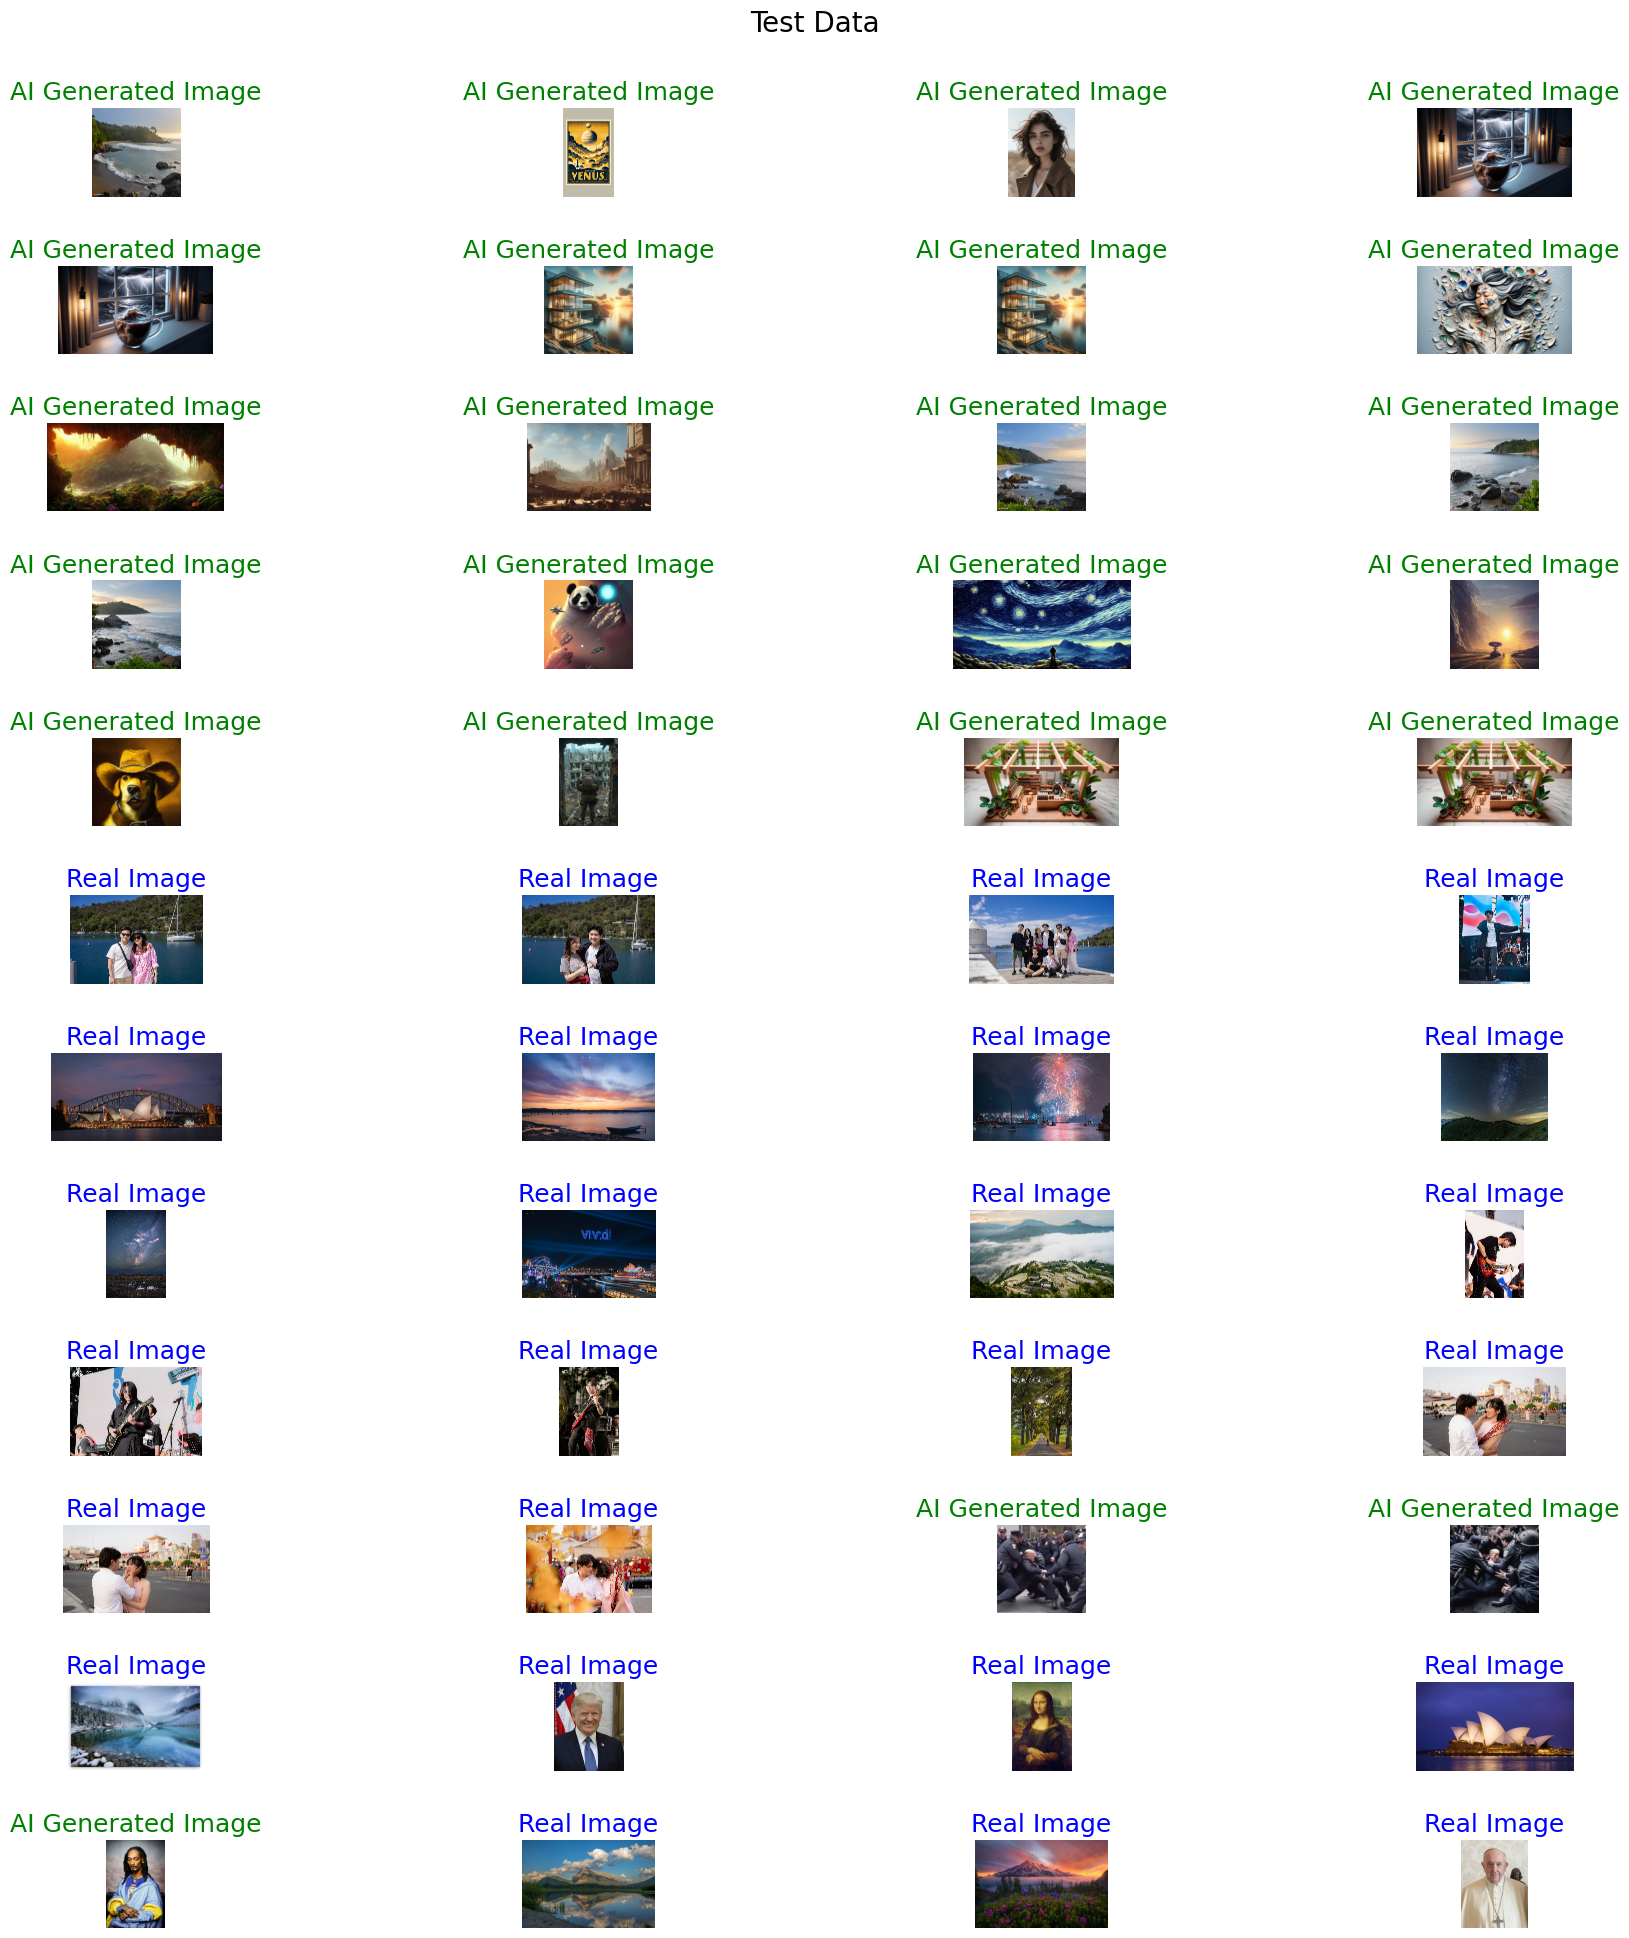

2/2 [==============================] - 5s 254ms/step
Best Threshold: 0.595959595959596


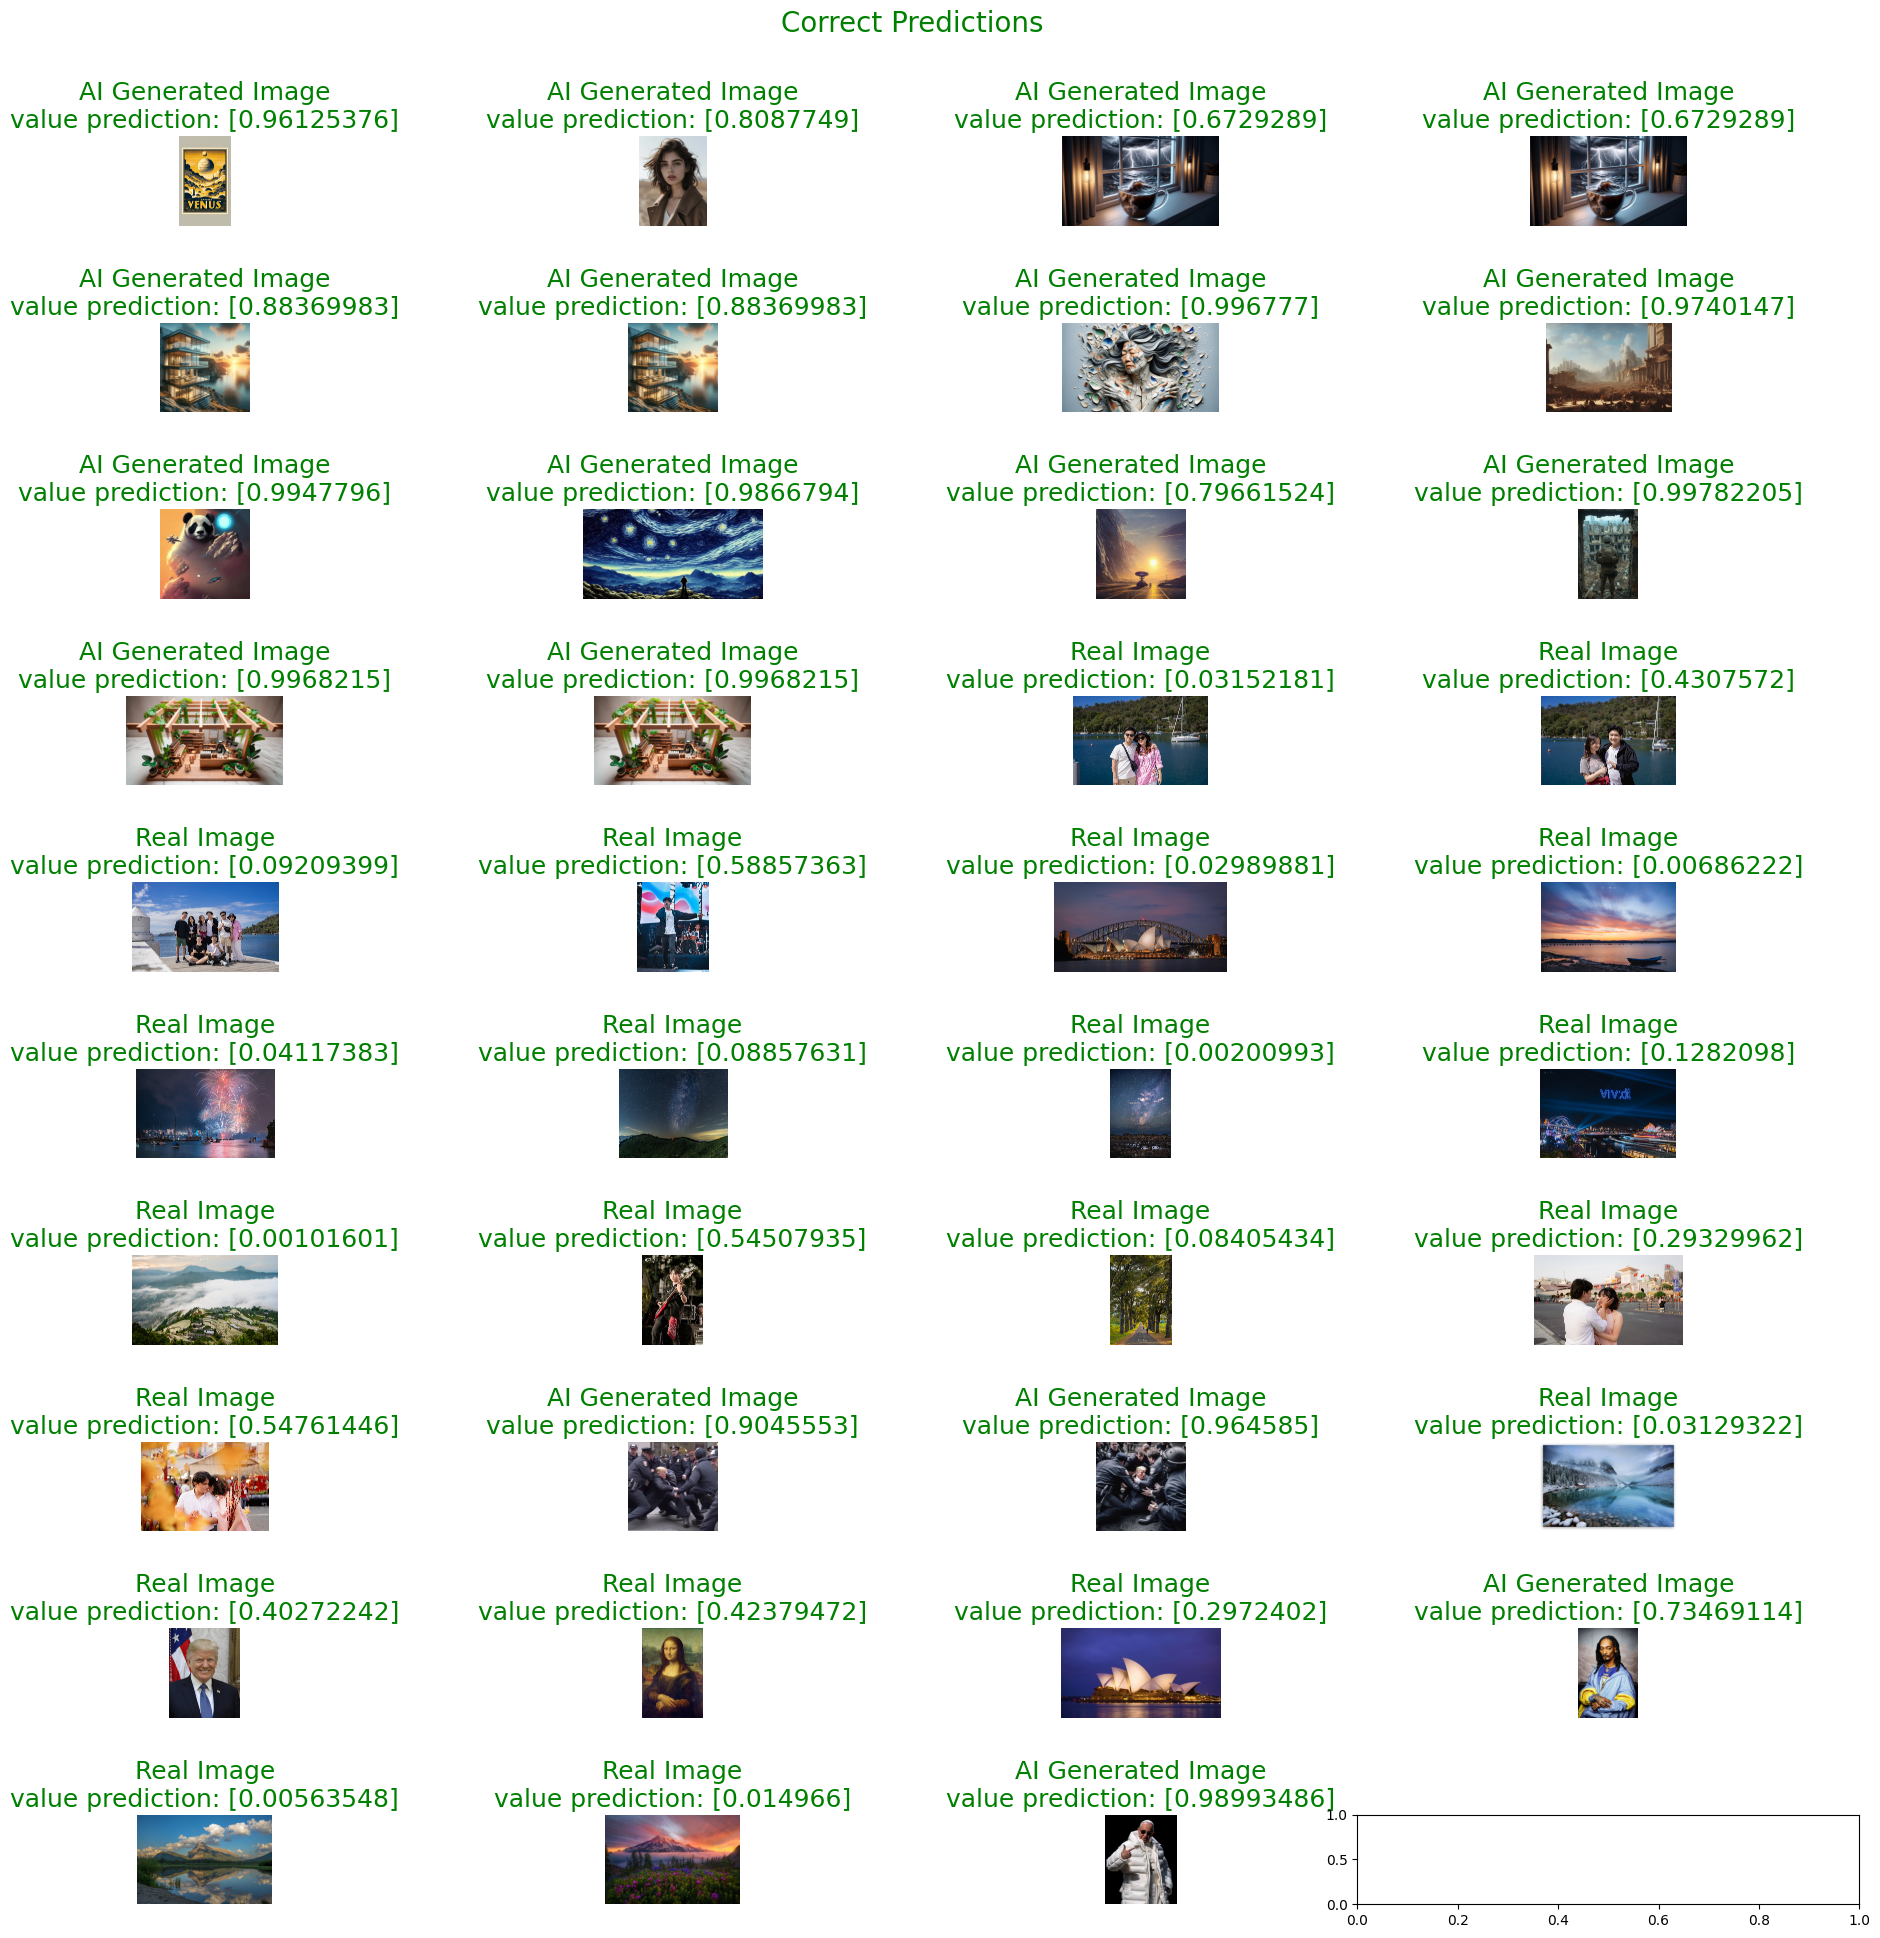

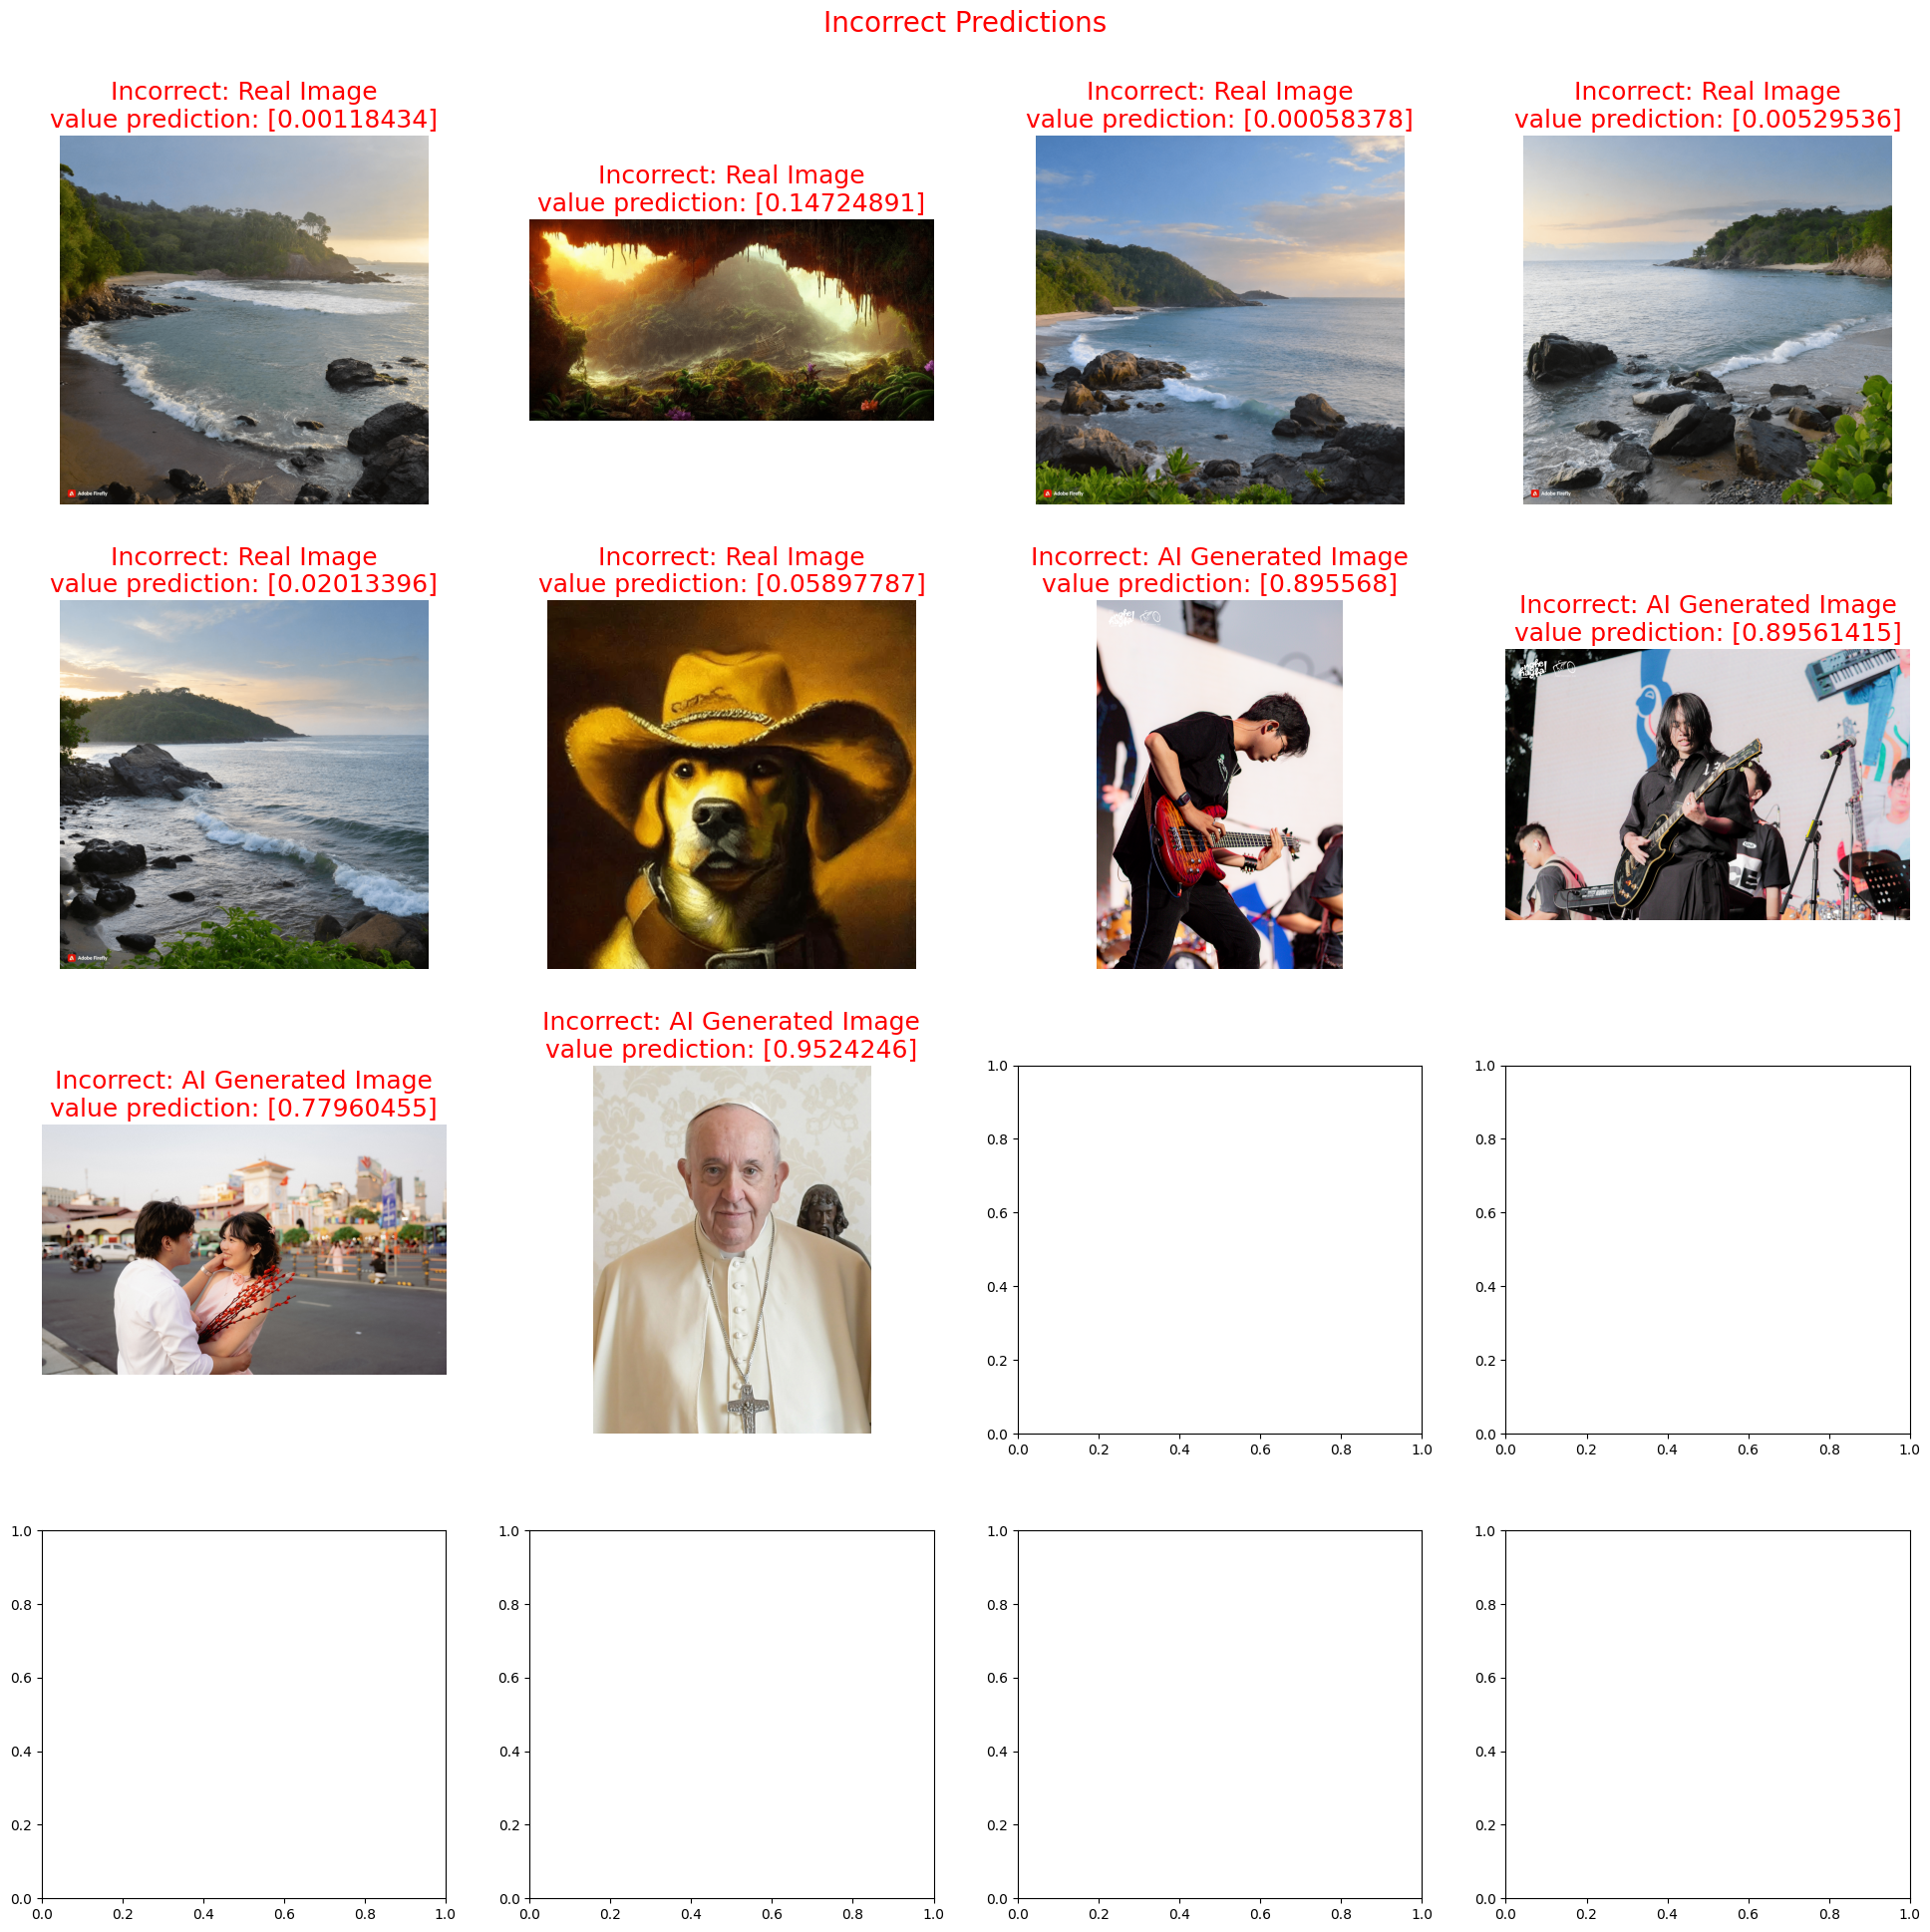

Test Accuracy: 0.7959183673469388


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the model architecture
loaded_model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model (necessary before loading weights)
loaded_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Load the weights into the model
loaded_model.load_weights("weights/ai_human_classify_model_weights_efficientnetb7.h5")

# get label of data
labels_file_path = "./data/Data - Is GenAI Test/file_names.csv"
df_data = load_image_labels(labels_file_path)
labels = df_data['Is GenAI'].tolist()
labels = [1 if label == 'Yes' else 0 for label in labels]
labels = np.array(labels)

# get all images
data_path = "./data/Data - Is GenAI Test"
images_name = df_data['Filename'].tolist()
image_paths = []
# load all the image path that ends with .png into the images_paths list
for filename in images_name:
    image_path = os.path.join(data_path, filename)
    image_paths.append(image_path)

# Load all PNG images in the image_path list and its label
images = [Image.open(image_path) for image_path in image_paths]

predict_images = [preprocess_image_function(image) for image in images]

# Preprocess the images
predict_images = np.array(predict_images)

# Define a common figure size for all plots
common_fig_size = (20, 20)

# plot the images and their labels with improved formatting
num_rows = 12
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=common_fig_size)

for image, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    label_title = "AI Generated Image" if label == 1 else "Real Image"
    ax.set_title(label_title, fontdict={'fontsize': 18, 'color': 'green' if label == 1 else 'blue'})
    ax.axis('off')
plt.suptitle("Test Data", fontsize=20, color='black')
plt.tight_layout(pad=3.0)
plt.show()


# Predict the labels for the images
predictions = loaded_model.predict(predict_images)




# Define a range of threshold values to try
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_f1 = 0

# Iterate through the thresholds
for threshold in thresholds:
    # Convert prediction probabilities to binary labels using the current threshold
    binary_predictions = (predictions > threshold).astype(int)

    # Calculate performance metrics on the validation set
    precision = precision_score(labels, binary_predictions, zero_division=0)
    recall = recall_score(labels, binary_predictions, zero_division=0)
    f1 = f1_score(labels, binary_predictions, zero_division=0)

    # Update the best threshold if the current f1 score is better than the previous best
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)


#Convert the predictions to binary labels (0 or 1)
binary_predictions = (predictions > best_threshold).astype(int)



# Separate the images into correct and incorrect categories based on predictions
correct_images = []
incorrect_images = []

for i, (image, prediction, label, value_prediction) in enumerate(zip(images, binary_predictions, labels, predictions)):
    if prediction == label:
        correct_images.append((image, prediction, value_prediction))
    else:
        incorrect_images.append((image, prediction, value_prediction))

# Rows and Col for correct images
num_rows_correct = 10
num_cols_correct = 4

# Display correct images
fig, axes = plt.subplots(num_rows_correct, num_cols_correct, figsize=common_fig_size)
for i, (image, prediction, value_prediction) in enumerate(correct_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    prediction_title = "AI Generated Image" if prediction == 1 else "Real Image"
    ax.set_title(prediction_title +   "\n" + "value prediction: {}".format(value_prediction), fontdict={'fontsize': 18, 'color': 'green'})
    ax.axis('off')
plt.suptitle("Correct Predictions", fontsize=20, color='green')
plt.tight_layout(pad=3.0)
plt.show()


# Rows and Col for incorrect images
num_rows_incorrect = 4
num_cols_incorrect = 4


# Display incorrect images
fig, axes = plt.subplots(num_rows_incorrect, num_cols_incorrect, figsize=common_fig_size)
for i, (image, prediction, value_prediction) in enumerate(incorrect_images[:num_rows*num_cols]):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(image)
    prediction_title = "AI Generated Image" if prediction == 1 else "Real Image"
    ax.set_title("Incorrect: " + prediction_title  + "\n" +  "value prediction: {}".format(value_prediction), fontdict={'fontsize': 18, 'color': 'red'})
    ax.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=20, color='red')
plt.tight_layout(pad=3.0)
plt.show()

# Calculate and print the test accuracy
test_accuracy = len(correct_images) / len(images)
print("Test Accuracy:", test_accuracy)